### Python library imports

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import numpy as np

from scipy.signal import savgol_filter as savitzky_golay

In [2]:
filename = 'oh3573s2.ts'
threshold_deviation = 3.
n_iter = 100  # max number of iterations
channels_of_interest = [4, ]

In [3]:
with open(filename, 'r') as fin:
    # human readable string for information
    comment = fin.readline()
    # timestamps [channel velocities]
    header = fin.readline()
    data = fin.readlines()

chan_vel = np.array(header.strip().split(',')[1:-1], dtype=float)

for cntr, line in enumerate(data):
    if cntr < 1:
        spectrum_data = np.array(line.strip().split(',')[:-1], dtype=float)
    else:
        spectrum_data = np.vstack([spectrum_data, np.array(line.strip().split(',')[:-1], dtype=float)])

timestamps = spectrum_data[:,0]
spectra = spectrum_data[:,1:]
[nts, nch] = spectra.shape

In [4]:
debug = False  # show more verbose output to help with development and debug
# choose channel with strong signal
max_chan_idx = spectra.max(axis=0).argsort()[-1]
# choose channel with weak signal
min_chan_idx = spectra.max(axis=0).argsort()[0]
debug_channels = [max_chan_idx, min_chan_idx]

### Fit, detrend and remove outliers recursively

In [5]:
def find_outlier(data, sigma=3.):
    for channel in range(nch):
        outliers[:, channel] = data[:, channel] > np.mean(data[:, channel])+sigma*np.std(data[:, channel])
        outliers[:, channel] = data[:, channel] < np.mean(data[:, channel])-sigma*np.std(data[:, channel])
    return outliers

In [6]:
def fit_trend(data, sigma=3.):
    [nts, nch] = data.shape
    fitted_trend = np.empty(data.shape)
    outliers = np.empty(data.shape, dtype=bool)
    
    for channel in range(nch):
        fitted_trend[:, channel] = savitzky_golay(data[:, channel], 21, 3)
        detrended = data[:, channel] - fitted_trend[:, channel]
        
        threshold = np.mean(detrended) + sigma*np.std(detrended)
        outliers[:, channel] = np.abs(detrended) > threshold
        
    return fitted_trend, outliers

In [7]:
def show_fit(x,
             raw_y,
             clean_y,
             outliers,
             trend = None,
             channels = None):

    if channels is None:
        channels = [0]

    fig, ax = plt.subplots(nrows=1,
                           ncols=len(channels),
                           figsize=(17,3),
                           facecolor='white')
    for cnt, channel in enumerate(channels):
        chan_data = raw_y[:, channel]
        chan_clean_data = clean_y[:, channel]
        ax[cnt].plot(x, chan_data, 'b.', label='channel {}'.format(channel))
        ax[cnt].plot(x[outliers[:, channel]],
                     chan_data[outliers[:, channel]],
                     'r.')
        if trend is not None:
            ax[cnt].plot(x, trend[:, channel], 'k-')
        ax[cnt].plot(x[outliers[:, channel]],
                     chan_clean_data[outliers[:, channel]],
                     'm*')
        ax[cnt].legend(loc=0)

In [8]:
done = False
cnt = 0
remove_idx = np.zeros(spectra.shape, dtype=bool)
clean_data = spectra.copy()
while not done:
    fitted_trend, outliers = fit_trend(clean_data, sigma=threshold_deviation)

    if np.nonzero(outliers)[0].size < 1:
        done = True
        break

    clean_data[outliers] = fitted_trend[outliers]
    remove_idx = (remove_idx | outliers)

    if debug:
        show_fit(timestamps,
                 spectra,
                 clean_data,
                 remove_idx,
                 trend=fitted_trend,
                 channels=debug_channels)
    
    cnt += 1
    if cnt > n_iter:
        done = True
        break

### Results

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


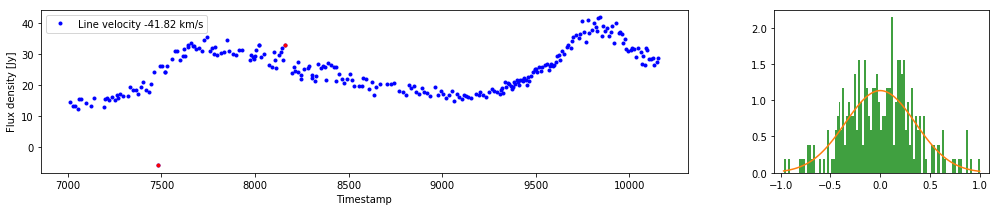

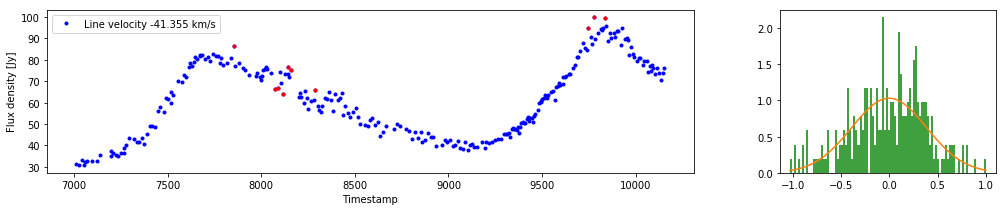

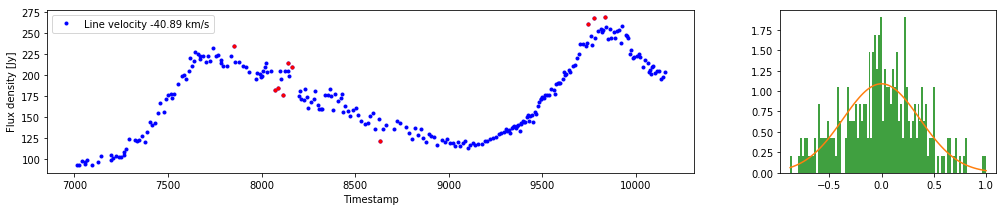

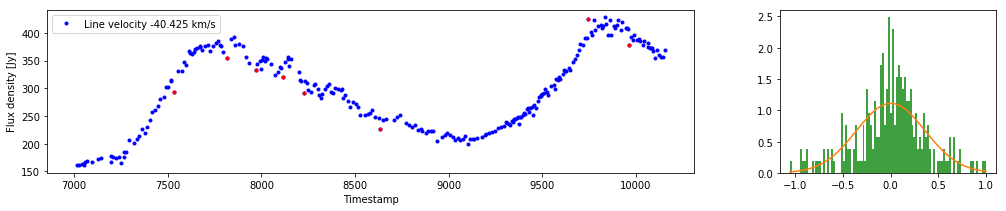

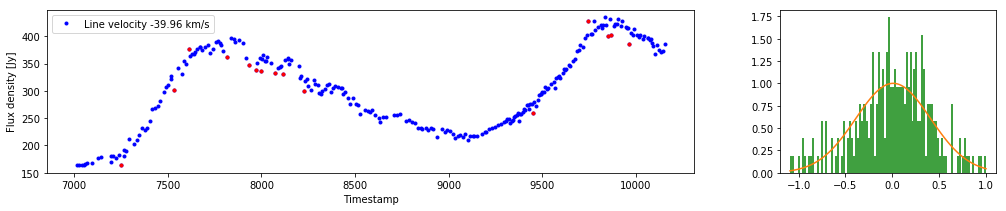

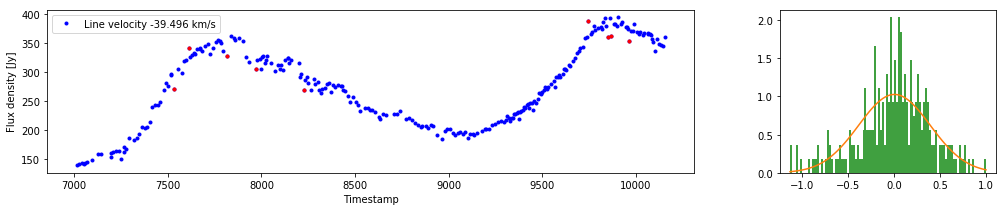

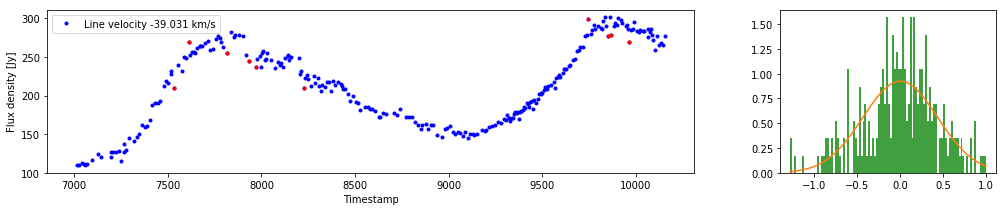

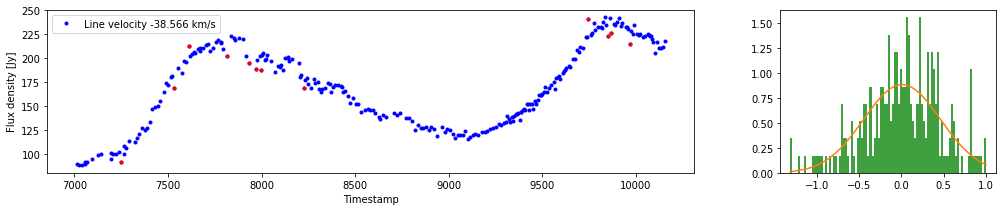

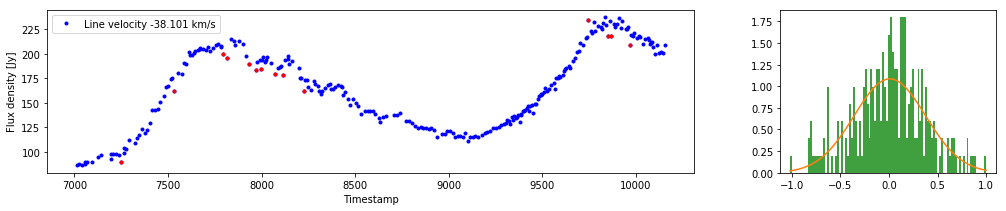

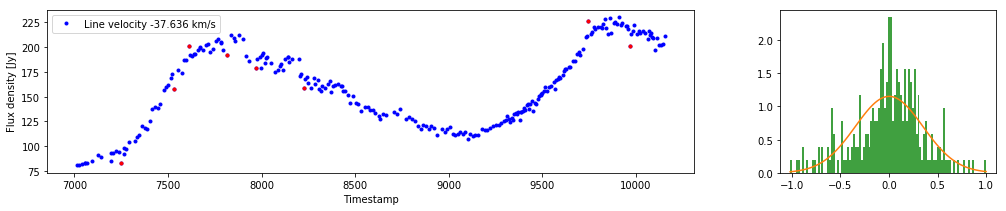

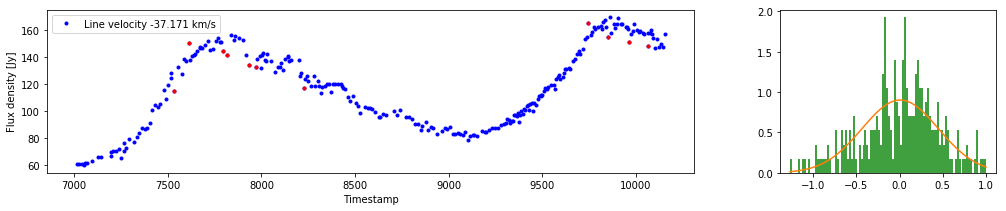

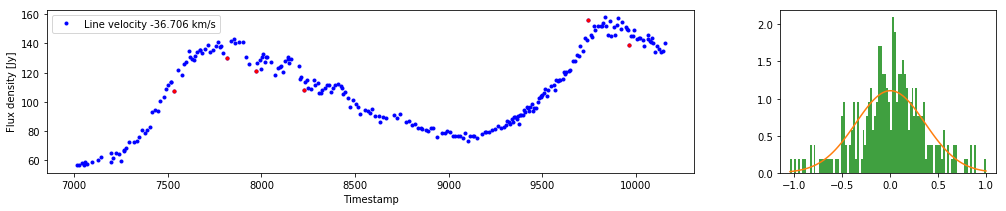

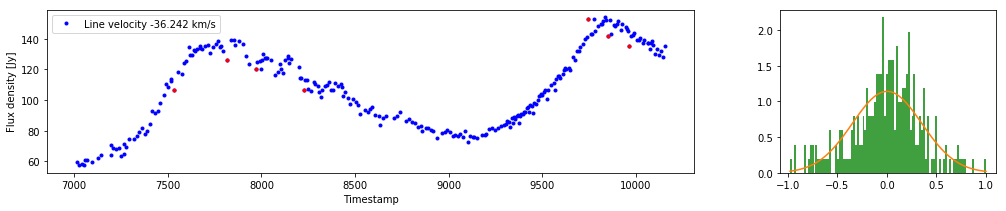

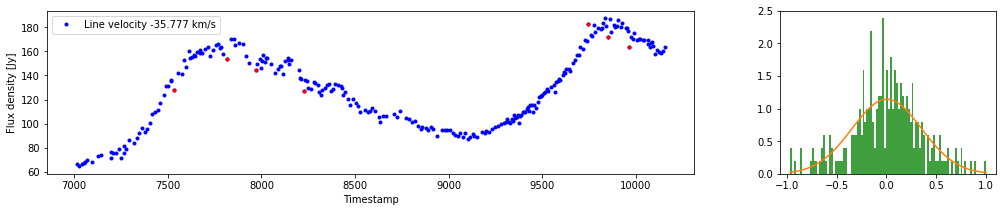

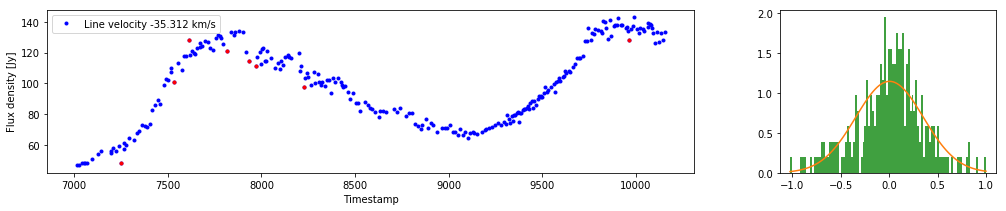

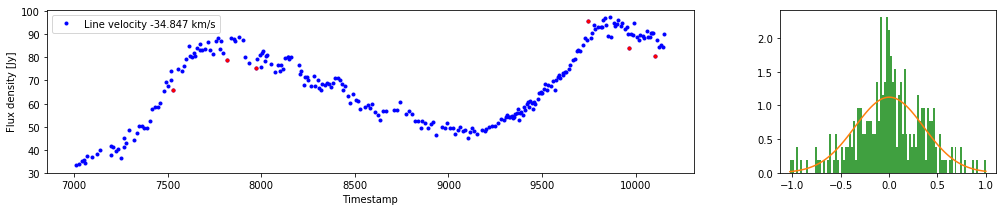

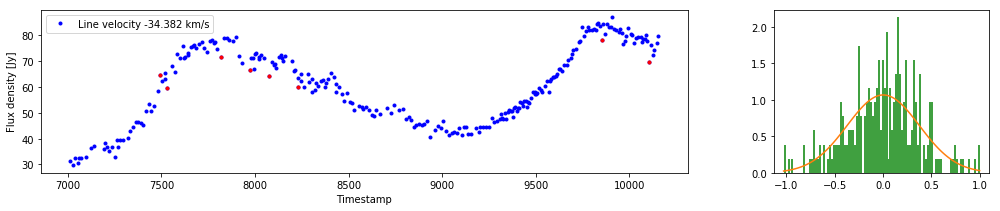

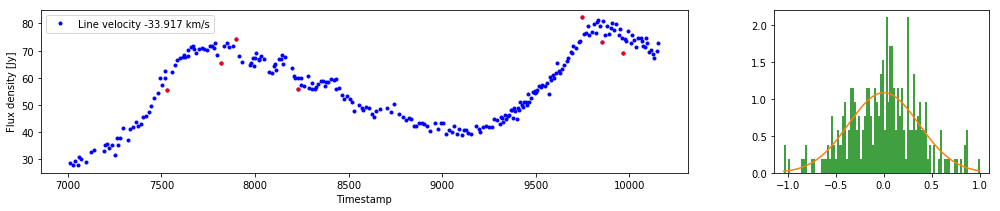

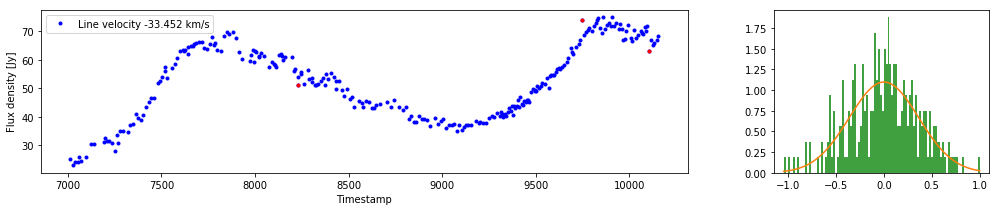

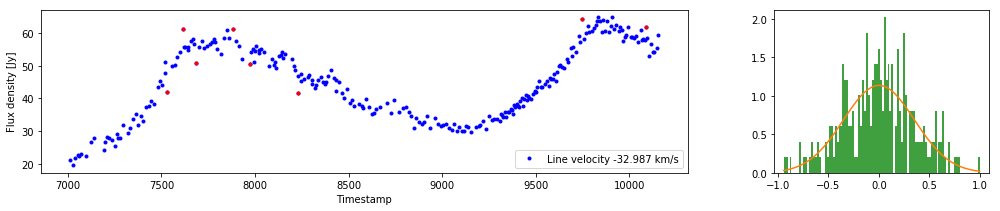

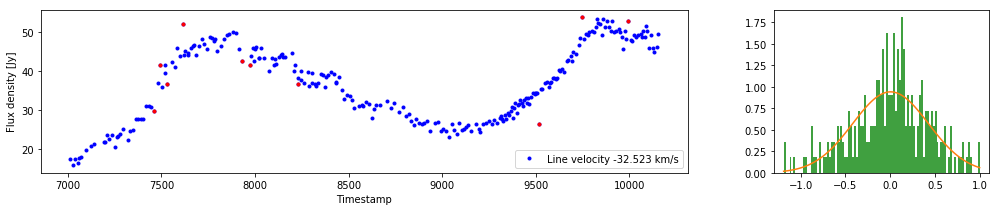

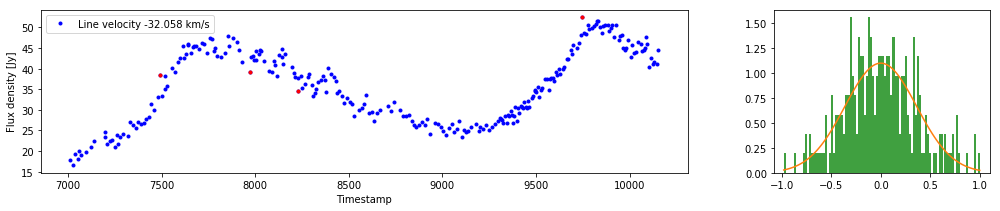

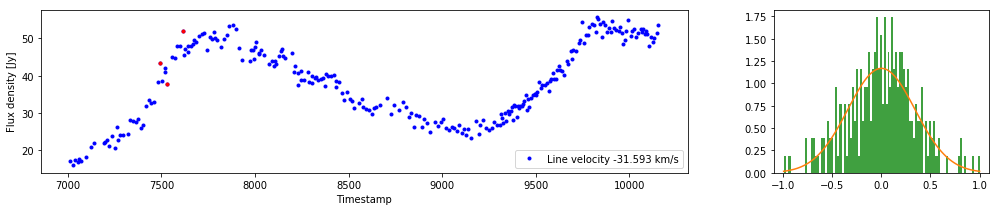

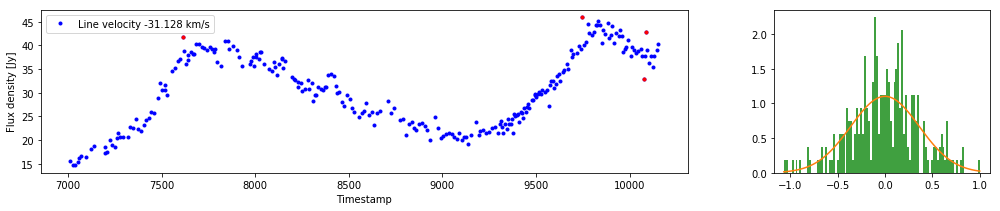

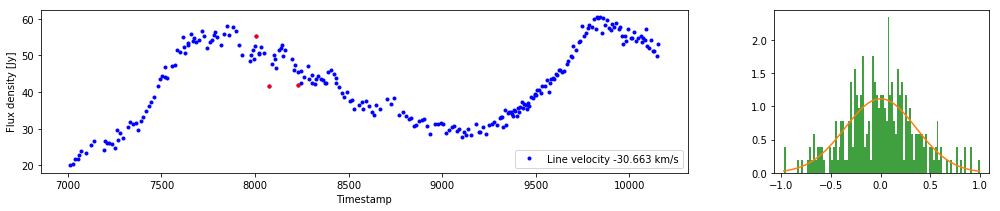

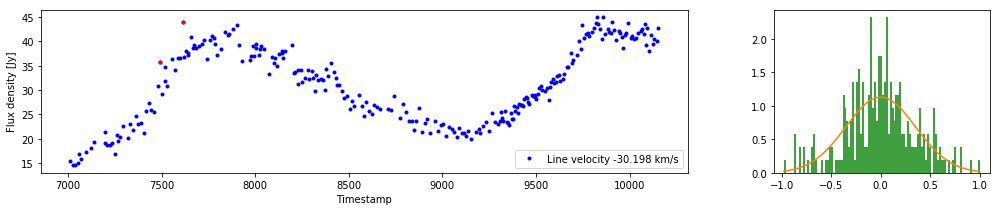

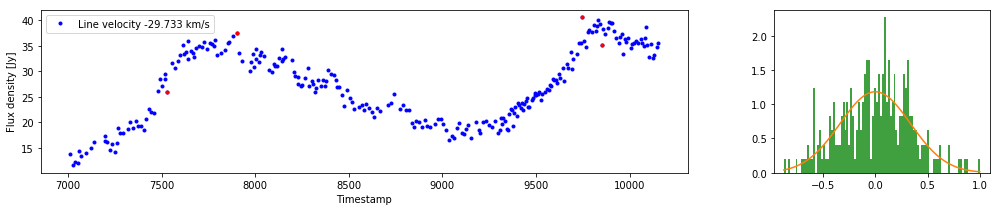

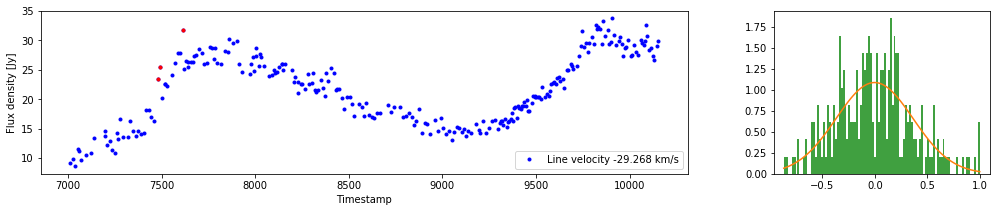

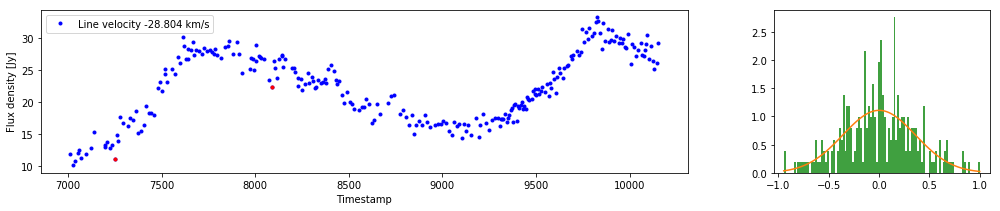

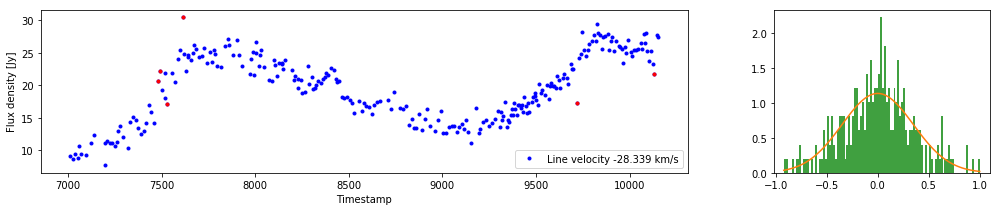

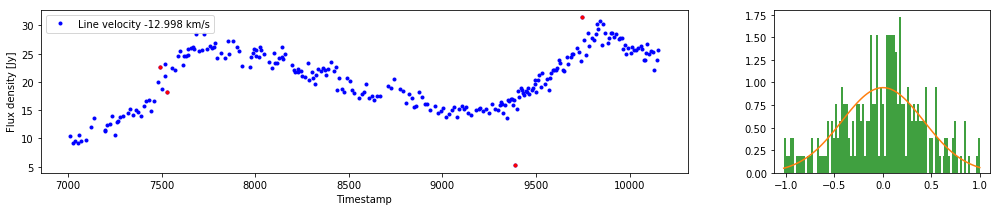

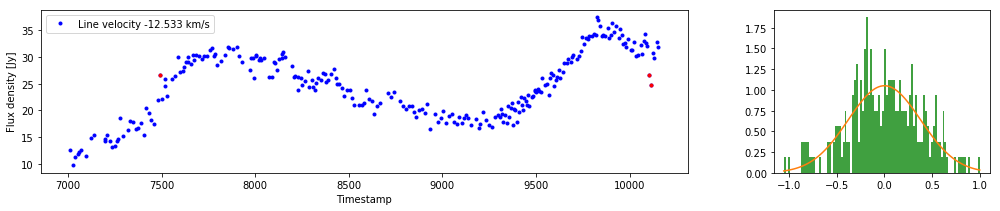

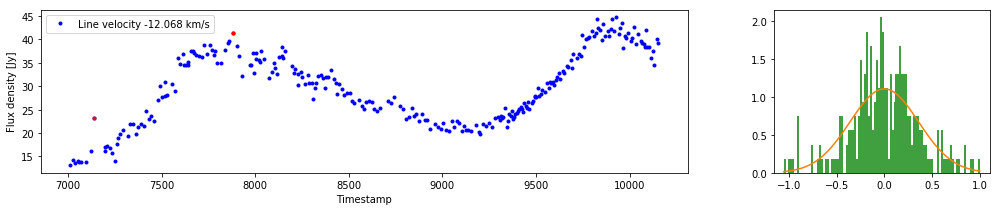

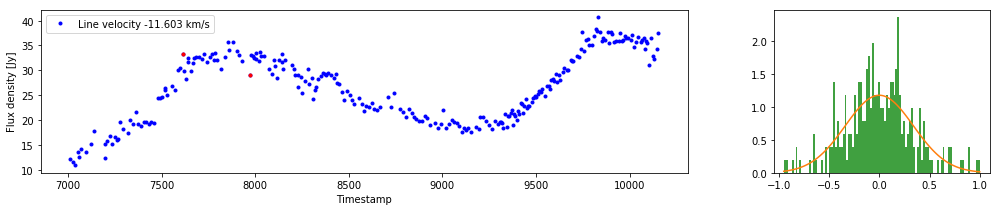

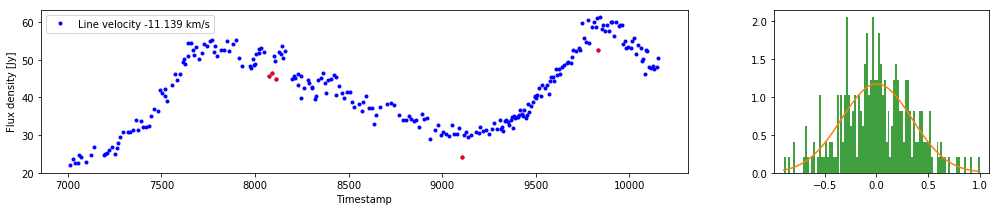

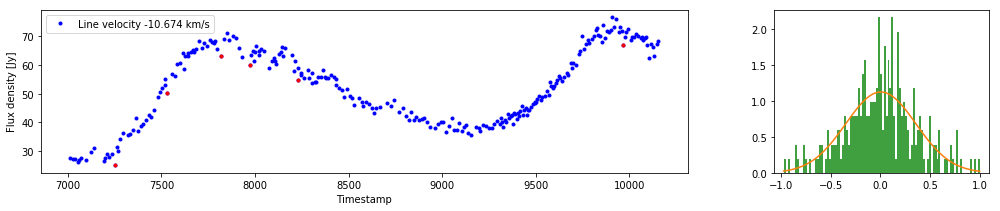

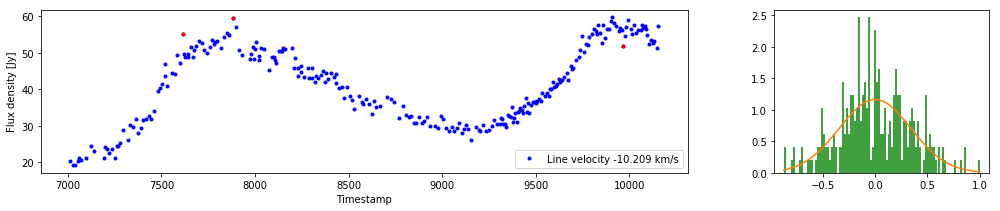

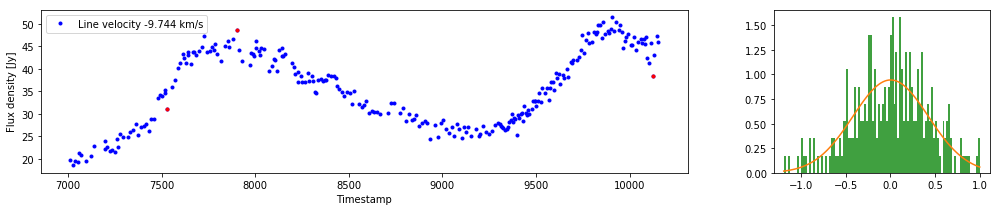

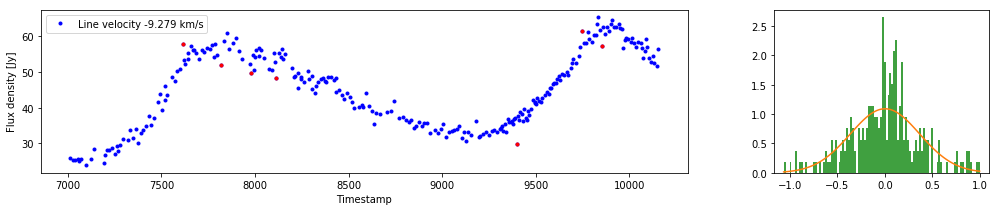

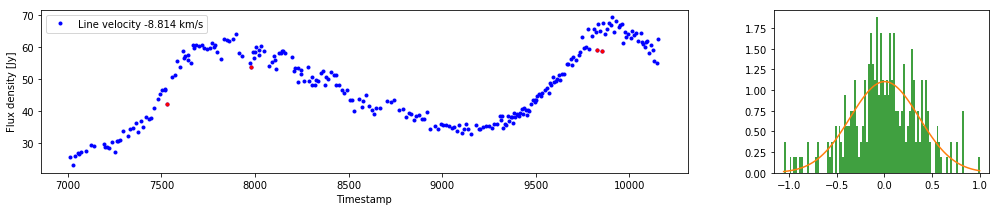

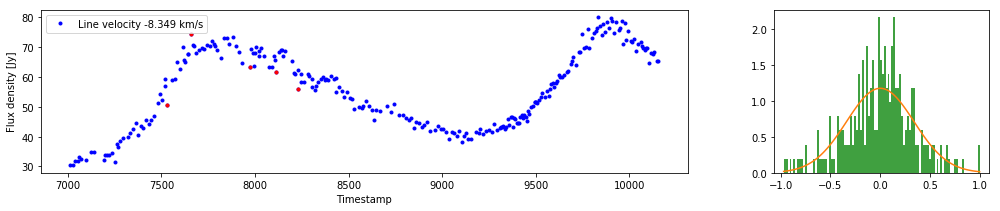

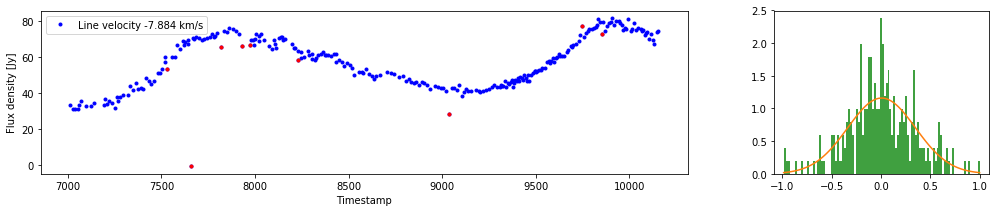

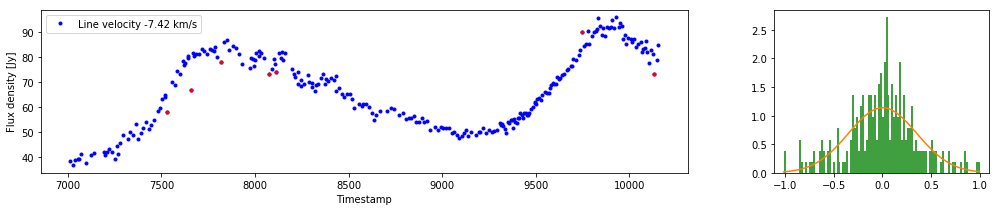

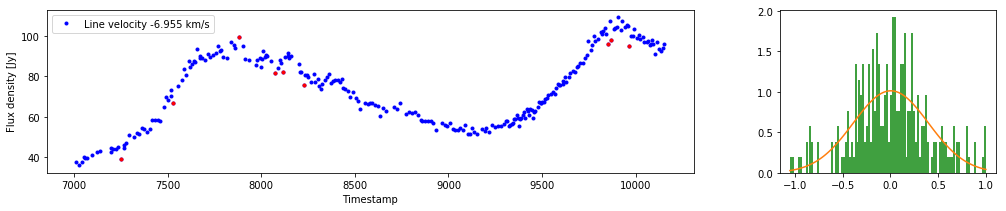

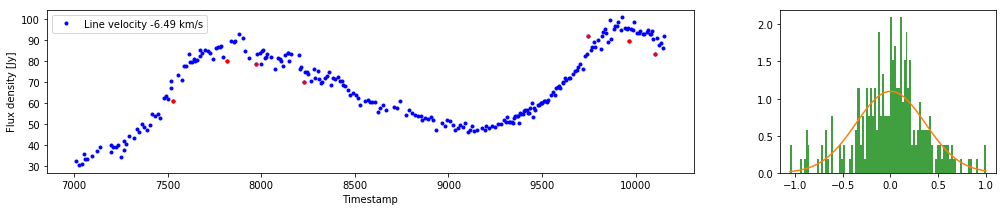

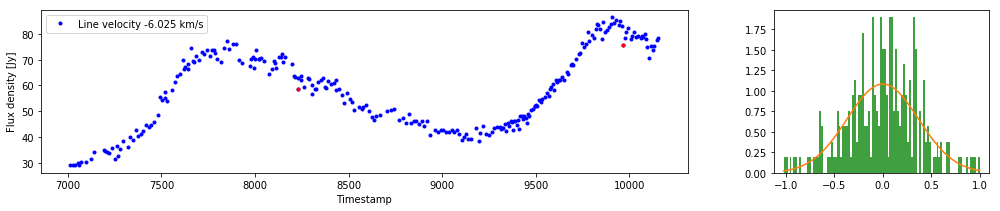

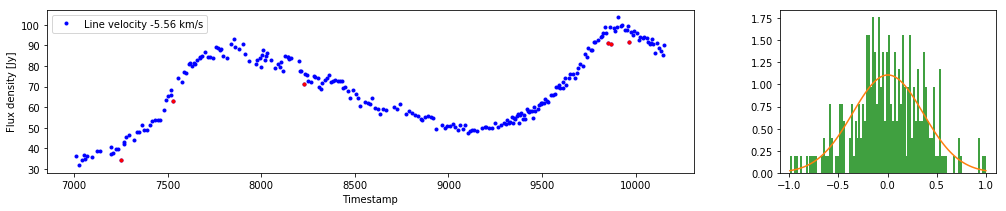

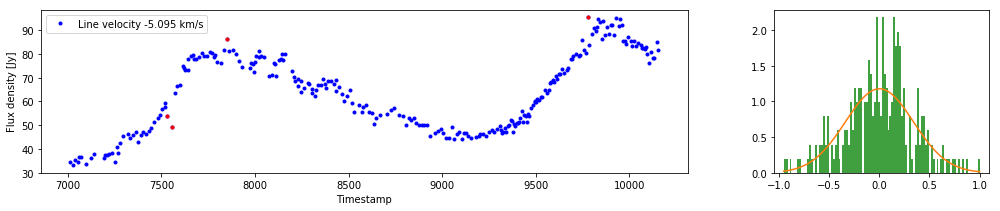

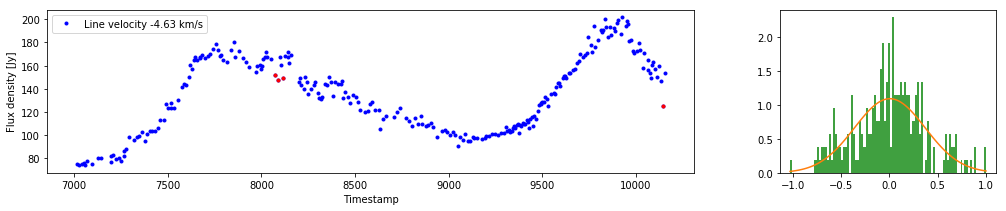

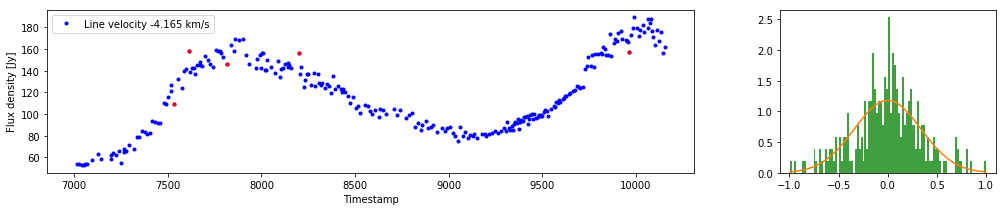

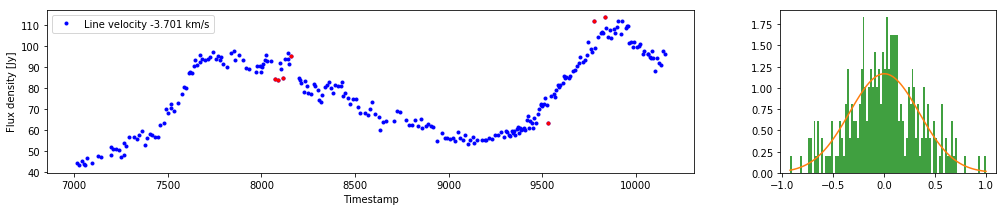

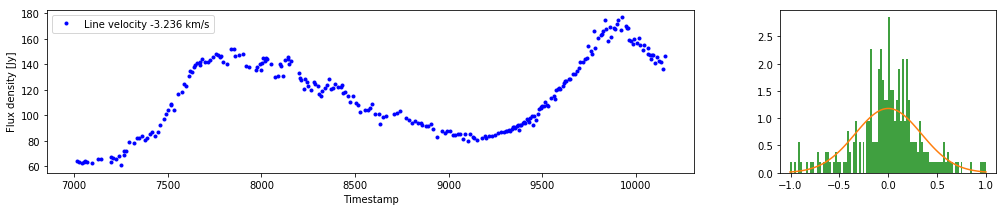

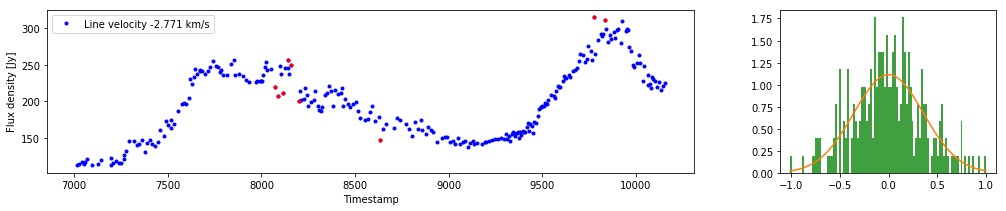

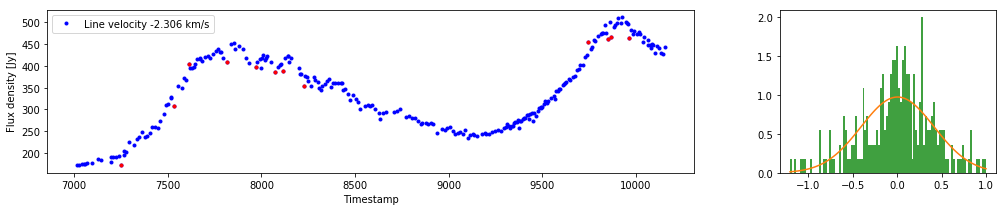

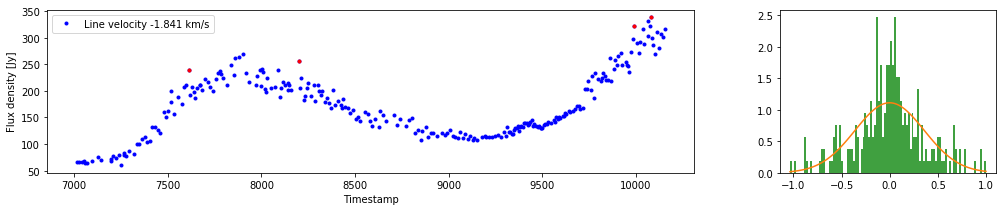

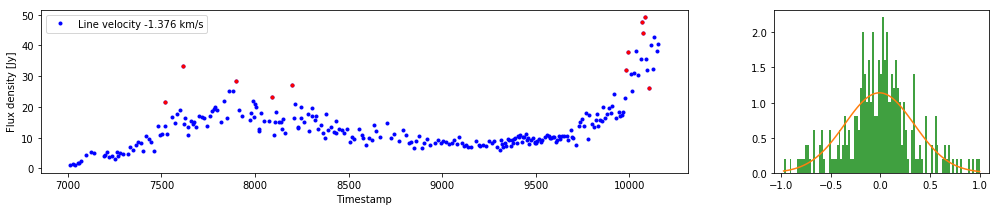

In [9]:
from matplotlib import gridspec
for channel in range(spectra.shape[1]):
    chan_data = spectra[:, channel]
    chan_clean_data = clean_data[:, channel]
    trend = fitted_trend[:, channel]
    
    fig= plt.subplots(figsize=(17,3),
                      facecolor='white')
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    ax0.plot(timestamps,
             chan_data,
             'b.',
             label=r'Line velocity {} km/s'.format(chan_vel[channel]))
    ax0.plot(timestamps[remove_idx[:, channel]],
             chan_data[remove_idx[:, channel]],
             'r.')
    ax0.legend(loc=0)
    ax0.set_ylabel('Flux density [Jy]')
    ax0.set_xlabel('Timestamp')
   
    # the histogram of the data to check that sample noise is gaussion (white)
    ax1 = plt.subplot(gs[1])
    ts = timestamps[~remove_idx[:, channel]]
    detrend = chan_data[~remove_idx[:, channel]] - trend[~remove_idx[:, channel]]
    norm_data = np.apply_along_axis(func1d=lambda x: x/np.max(detrend), arr=detrend, axis=0)
    ax1.hist(norm_data, 100, density=1, facecolor='green', alpha=0.75)
    mean = np.mean(norm_data)
    variance = np.var(norm_data)
    sigma = np.sqrt(variance)
    x = np.linspace(min(norm_data), max(norm_data), 100)
    ax1.plot(x, mlab.normpdf(x, mean, sigma))

The blue graphs show the data trend over the timeseries with the red dots only as indication of the outliers identified.   
The outliers are removed and the trend fitted to the clean data subtraced to get detrended data showing sampling distribution.   
The histogram of the sampling distribution, especially for the stronger channels, indicate that the sampling distribution deviates from normal (Gaussian), as we expected.